In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 6089, done.
remote: Counting objects: 100% (1278/1278), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 6089 (delta 1091), reused 1182 (delta 1013), pack-reused 4811
Receiving objects: 100% (6089/6089), 2.94 GiB | 29.06 MiB/s, done.
Resolving deltas: 100% (4917/4917), done.
Updating files: 100% (504/504), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 7.2 MB/s eta 0:00:00


In [3]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 41.1 MB/s eta 0:00:00


In [4]:
# ! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

In [5]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
import scipy.stats as stats
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBRanker

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/ease_r_all.zip
/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/ease_r_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/mult_vae_2_all.zip
/kaggle/input/training-tuned-models/ease_r_xgbo

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender
from Recommenders.GraphBased.HHPRecommender import HHPRecommender
from Recommenders.GraphBased.TwoWayRankAggregationRecommender import TwoWayRankAggregationRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
config = {
    'tune_parameters': True,
    'n_trials': 50,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [11]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [12]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [13]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [21]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [22]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [23]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hhp.json', 'r') as params_file:
    params_hhp = json.load(params_file)
params_hhp

{'hybrid_lambda': 0.8450256587797654, 'topK': 61}

In [24]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_twra.json', 'r') as params_file:
    params = json.load(params_file)

params_twra = {
    'base_f_algorithm': params['base_f_algorithm'], 
    'base_b_algorithm': params['base_b_algorithm'], 
    'convex_lambda': params['convex_lambda'],
}

if params['base_f_algorithm'] == 'p3':
    params_twra['f_params'] = {
        'topK': params['f_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'p3alpha':
    params_twra['f_params'] = {
        'alpha': params['f_p3a_alpha'],
        'topK': params['f_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'rp3beta':
    params_twra['f_params'] = {
        'alpha': params['f_rp3_alpha'],
        'beta': params['f_rp3_beta'],
        'topK': params['f_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['f_params'] = {
        'hybrid_lambda': params['f_hhp_hybrid_lambda'],
        'topK': params['f_hhp_topK'],
    }

if params['base_b_algorithm'] == 'p3':
    params_twra['b_params'] = {
        'topK': params['b_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'p3alpha':
    params_twra['b_params'] = {
        'alpha': params['b_p3a_alpha'],
        'topK': params['b_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'rp3beta':
    params_twra['b_params'] = {
        'alpha': params['b_rp3_alpha'],
        'beta': params['b_rp3_beta'],
        'topK': params['b_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['b_params'] = {
        'hybrid_lambda': params['b_hhp_hybrid_lambda'],
        'topK': params['b_hhp_topK'],
    }

In [25]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_rp3_recall@50.json', 'r') as params_file:
    params_rp3_recall = json.load(params_file)
params_rp3_recall

{'alpha': 0.2139985499567939, 'beta': 0.2194371742883361, 'topK': 154}

In [26]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_item_knn_recall@50.json', 'r') as params_file:
    params_item_knn_recall = json.load(params_file)
params_item_knn_recall

{'topK': 62,
 'shrink': 480,
 'similarity': 'tversky',
 'feature_weighting': 'BM25',
 'tversky_alpha': 0.03679620043176055,
 'tversky_beta': 1.9314395554791928}

In [27]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip', 
    '/kaggle/working/slim_recall_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_train_validation.zip', 
    '/kaggle/working/slim_recall_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_all.zip', 
    '/kaggle/working/slim_recall_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip', 
    '/kaggle/working/mult_vae_2_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip', 
    '/kaggle/working/mult_vae_2_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_all.zip', 
    '/kaggle/working/mult_vae_2_all.zip', 
)

'/kaggle/working/mult_vae_2_all.zip'

In [28]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_train = recommender_pure_svd.USER_factors
item_factors_train = recommender_pure_svd.ITEM_factors

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_xgboost_train_validation')

recommender_hhp = HHPRecommender(URM_train)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train)
# recommender_als.load_model('/kaggle/working/', 'als_xgboost_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_xgboost_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train)
recommender_item_recall.fit(**params_item_knn)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1115.96 column/sec. Elapsed time 20.02 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 727.66 column/sec. Elapsed time 17.90 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2604.40 column/sec. Elapsed time 8.58 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity colu

In [29]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions


In [30]:
print('Item KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_item)
display(result_df)
print('RP3 beta')
result_df, _ = evaluator.evaluateRecommender(recommender_rp3)
display(result_df)
print('P3 alpha')
result_df, _ = evaluator.evaluateRecommender(recommender_p3a)
display(result_df)
print('User KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_user)
display(result_df)
print('NMF')
result_df, _ = evaluator.evaluateRecommender(recommender_nmf)
display(result_df)
print('Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd)
display(result_df)
print('Scaled Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_scaled_svd)
display(result_df)
print('Item Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd_item)
display(result_df)
print('SLIM BPR')
result_df, _ = evaluator.evaluateRecommender(recommender_slim_bpr)
display(result_df)
print('SLIM Elastic')
result_df, _ = evaluator.evaluateRecommender(recommender_slim)
display(result_df)
print('EASE R')
result_df, _ = evaluator.evaluateRecommender(recommender_ease_r)
display(result_df)
print('IALS')
result_df, _ = evaluator.evaluateRecommender(recommender_ials)
display(result_df)
print('MultVAE')
result_df, _ = evaluator.evaluateRecommender(recommender_vae)
display(result_df)
print('HHP')
result_df, _ = evaluator.evaluateRecommender(recommender_hhp)
display(result_df)
print('TWRA')
result_df, _ = evaluator.evaluateRecommender(recommender_twra)
display(result_df)
# print('ALS')
# result_df, _ = evaluator.evaluateRecommender(recommender_als)
# display(result_df)

Item KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 8.89 sec. Users per second: 1176


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079141,0.134235,0.112828,0.038628,0.066894,0.232462,0.124094,0.093029,0.464327,0.297299,...,0.802826,0.372773,0.802826,0.075712,10.418373,0.997966,0.221413,0.803337,1.652023,0.383676


RP3 beta
EvaluatorHoldout: Processed 10456 (100.0%) in 8.80 sec. Users per second: 1189


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079658,0.136429,0.115204,0.038171,0.066535,0.231172,0.124353,0.094189,0.47303,0.294753,...,0.802826,0.37976,0.802826,0.096602,10.808804,0.998526,0.282504,0.833442,1.437561,0.390783


P3 alpha
EvaluatorHoldout: Processed 10456 (100.0%) in 8.89 sec. Users per second: 1176


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.076664,0.128535,0.10787,0.037284,0.064338,0.227507,0.119981,0.089628,0.456676,0.289145,...,0.802826,0.366631,0.802826,0.072251,10.504764,0.998262,0.21129,0.809998,1.371811,0.386528


User KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 12.26 sec. Users per second: 853


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.061477,0.112346,0.096871,0.028592,0.05208,0.191056,0.099645,0.075218,0.406848,0.232673,...,0.802826,0.326628,0.802826,0.011358,7.735149,0.986167,0.033216,0.59644,3.662361,0.323459


NMF
EvaluatorHoldout: Processed 10456 (100.0%) in 11.51 sec. Users per second: 909


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.051415,0.084267,0.069573,0.024792,0.040821,0.165486,0.079928,0.059132,0.338849,0.201455,...,0.802826,0.272036,0.802826,0.018774,9.145243,0.997874,0.054903,0.705169,1.326454,0.362589


Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 10.67 sec. Users per second: 980


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.05022,0.086014,0.072432,0.023883,0.040909,0.164475,0.080074,0.059315,0.344109,0.197553,...,0.802826,0.276259,0.802826,0.005554,7.368601,0.992223,0.016243,0.568176,2.711888,0.326934


Scaled Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 12.79 sec. Users per second: 818


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.052802,0.090327,0.076977,0.025086,0.043651,0.170985,0.084357,0.062638,0.35635,0.206245,...,0.802826,0.286087,0.802826,0.013232,8.625793,0.996729,0.038694,0.665115,1.992554,0.343623


Item Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 14.23 sec. Users per second: 735


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.053395,0.088783,0.074181,0.025534,0.042764,0.173646,0.083816,0.062095,0.355777,0.20946,...,0.802826,0.285627,0.802826,0.018466,9.043891,0.997531,0.054003,0.697354,1.425533,0.361464


SLIM BPR
EvaluatorHoldout: Processed 10456 (100.0%) in 10.17 sec. Users per second: 1028


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.057154,0.100577,0.085625,0.026561,0.047843,0.179969,0.091756,0.068551,0.382269,0.217765,...,0.802826,0.306895,0.802826,0.030224,8.973277,0.994651,0.088387,0.691909,2.634383,0.346626


SLIM Elastic
EvaluatorHoldout: Processed 10456 (100.0%) in 12.47 sec. Users per second: 839


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079839,0.135985,0.114694,0.038588,0.0664,0.233862,0.124583,0.094144,0.472743,0.298541,...,0.802826,0.37953,0.802826,0.053029,10.313128,0.998528,0.155077,0.795222,1.619657,0.371056


EASE R
EvaluatorHoldout: Processed 10456 (100.0%) in 13.41 sec. Users per second: 780


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.075669,0.130841,0.110975,0.036575,0.064176,0.226216,0.119963,0.089983,0.458015,0.285959,...,0.802826,0.367706,0.802826,0.03758,9.809772,0.997871,0.109898,0.756409,1.876174,0.360689


IALS
EvaluatorHoldout: Processed 10456 (100.0%) in 14.67 sec. Users per second: 713


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.069539,0.122979,0.105423,0.032759,0.05783,0.209923,0.11029,0.083801,0.437835,0.260966,...,0.802826,0.351505,0.802826,0.024802,9.523511,0.998258,0.072532,0.734336,1.744761,0.356885


MultVAE
EvaluatorHoldout: Processed 10456 (100.0%) in 18.84 sec. Users per second: 555


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.066115,0.123357,0.107416,0.029619,0.054903,0.197963,0.106087,0.081851,0.435731,0.241465,...,0.802826,0.349816,0.802826,0.016447,7.902069,0.982289,0.048098,0.60931,3.855345,0.321449


HHP
EvaluatorHoldout: Processed 10456 (100.0%) in 9.41 sec. Users per second: 1111


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.065618,0.112422,0.094661,0.030697,0.05359,0.192652,0.101877,0.077508,0.406561,0.241416,...,0.802826,0.326397,0.802826,0.122002,11.292209,0.998984,0.356783,0.870716,1.245748,0.40712


TWRA
EvaluatorHoldout: Processed 10456 (100.0%) in 1.53 min. Users per second: 114


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079849,0.13748,0.116236,0.038436,0.066952,0.233366,0.125206,0.094666,0.472456,0.297263,...,0.802826,0.3793,0.802826,0.091709,10.679589,0.998218,0.268196,0.823479,1.638586,0.383197


In [31]:
cutoff = 50
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    if user_id == 0:
        print(recommendations)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_19/2461008040.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

[   0    1    2    3    9   28   35   53   57   75   76   84   86   97
  100  101  111  122  136  138  155  170  215  253  256  283  288  336
  341  366  385  402  428  485  492  505  514  533  591  617  636  693
  699  715  772  849  868  921  976 1056 1067 1082 1088 1131 1213 1257
 1287 1337 1421 1480 1489 1514 1545 1629 1744 1813 1913 1934 2002 2011
 2480 2498 2539 2724 2781 3156 3315 3728 4499 4749 6222 8500]


,ItemID
UserID,
0,0
0,1
0,2
0,3
0,9
...,...
13023,15027
13023,15028
13023,15668


In [32]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [33]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,0,False
1,0,1,False
2,0,2,False
3,0,3,False
4,0,9,False
...,...,...,...
1196652,13023,15027,False
1196653,13023,15028,False
1196654,13023,15668,False
1196655,13023,20107,False


In [34]:
training_dataframe.Label.sum()

20619

In [35]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [36]:
tmp = training_dataframe[training_dataframe['UserID'] == 0].copy()

scores = recommender_item._compute_item_score([0])
linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
linf_scores[0, :] = recommender_item._remove_seen_on_scores(0, linf_scores[0, :])
linf_scores

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [37]:
rank = np.argsort(linf_scores[0, :])[::-1]
rank[:50]

array([  35,  100,  505,  591,  693, 1480,  402,  617,  341,  122, 1421,
       1545,  428, 1082, 1287, 1337, 1213, 1088,  170,  138,  253, 1131,
       3156, 1056,  215, 3728,  514,  101, 2724, 1629,  485, 1913, 1257,
        772,   75, 4499,  385, 2539,  492,  636, 4749, 1934, 2480,  849,
       1813,  155, 2002, 1514,  976,  699])

In [38]:
tmp.ItemID.values.astype(int)

array([   0,    1,    2,    3,    9,   28,   35,   53,   57,   75,   76,
         84,   86,   97,  100,  101,  111,  122,  136,  138,  155,  170,
        215,  253,  256,  283,  288,  336,  341,  366,  385,  402,  428,
        485,  492,  505,  514,  533,  591,  617,  636,  693,  699,  715,
        772,  849,  868,  921,  976, 1056, 1067, 1082, 1088, 1131, 1213,
       1257, 1287, 1337, 1421, 1480, 1489, 1514, 1545, 1629, 1744, 1813,
       1913, 1934, 2002, 2011, 2480, 2498, 2539, 2724, 2781, 3156, 3315,
       3728, 4499, 4749, 6222, 8500])

In [39]:
item_list = tmp.ItemID.values.astype(int)

positions = np.zeros(n_items, dtype=int)
positions[rank] = np.arange(n_items)
positions[item_list]

array([21981,  7491,  7492,  7493,  7498,  7473,     0,  7540,  7544,
          34,  7519,  7527,  7529,  7410,     1,    27,    50,     9,
        7423,    19,    45,    18,    24,    20,  7687,  7584,  7589,
        7637,     8,  7146,    36,     6,    12,    30,    38,     2,
          26,  7087,     3,     7,    39,     4,    49,  7261,    33,
          43,  8148,    60,    48,    23,  8297,    13,    17,    21,
          16,    32,    14,    15,    10,     5,  6152,    47,    11,
          29,    66,    44,    31,    41,    46,  5951,    42,  6456,
          37,    28,    58,    22,    67,    25,    35,    40,    62,
        4623])

In [40]:
recommended = np.isin(item_list, rank[:10], assume_unique=True)
recommended.astype(int)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [41]:
training_dataframe = training_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        training_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        training_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        training_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()

item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

# todo: cluster if possible the similarity matrix of KNN or RP3, then add for each users some features 
# that represent something like users that like only items from the same cluster (e.g. items variability)
# same can be done with users and items reversed (i.e. using User KNN)

recommended_columns = [col for col in training_dataframe.columns if col.endswith('_Recommended')]
training_dataframe['Counter_Recommended'] = training_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in training_dataframe.columns if col.endswith('_RankPosition')]
training_dataframe['Mean_RankPosition'] = training_dataframe[position_columns].mean(axis=1)
training_dataframe['Std_RankPosition'] = training_dataframe[position_columns].std(axis=1)
training_dataframe['Skew_RankPosition'] = training_dataframe[position_columns].skew(axis=1)
training_dataframe['Kurtosis_RankPosition'] = training_dataframe[position_columns].kurtosis(axis=1)

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/223847650.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
/tmp/ipykernel_19/223847650.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,MaxSimilarityToSeenRP3,MinSimilarityToSeenRP3,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition
0,0,0,False,0.000000,21981.0,0.0,0.046025,50.0,0.0,0.172726,...,0.000000,0.0,0.000000,NaN,NaN,0,4425.266667,8540.481414,1.690335,1.089555
1,0,1,False,0.000000,7491.0,0.0,0.045999,51.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,4322.400000,4490.692482,0.483295,-1.236144
2,0,2,False,0.000000,7492.0,0.0,0.102911,4.0,1.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,2,5096.733333,6402.640643,1.247515,1.339647
3,0,3,False,0.000000,7493.0,0.0,0.071723,12.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,3832.933333,4182.182589,0.297977,-1.887497
4,0,9,False,0.000000,7498.0,0.0,0.094539,5.0,1.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,1,3779.200000,4232.622578,0.372173,-1.698712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196652,13023,15027,False,0.116225,38.0,0.0,0.069694,449.0,0.0,0.000000,...,0.032752,0.0,0.009631,2.527193,4.413497,0,3417.333333,7466.410676,2.377824,4.263699
1196653,13023,15028,False,0.000000,21756.0,0.0,0.108215,196.0,0.0,0.000000,...,0.024615,0.0,0.003590,6.559137,41.022255,0,6171.733333,9757.290728,1.172421,-0.737149
1196654,13023,15668,False,0.112155,40.0,0.0,0.056786,675.0,0.0,0.035712,...,0.029363,0.0,0.005710,4.496439,18.280294,0,4282.400000,7747.610782,1.676437,0.965942
1196655,13023,20107,False,0.099075,45.0,0.0,0.056417,694.0,0.0,0.035768,...,0.043723,0.0,0.010818,3.013967,7.255245,0,1080.800000,1605.743272,3.061382,10.585679


In [42]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
item_popularity = item_popularity / np.max(item_popularity)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
user_popularity = user_popularity / np.max(user_popularity)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len,mainstream_user,mainstream_item
0,0,0,False,0.000000,21981.0,0.0,0.046025,50.0,0.0,0.172726,...,NaN,0,4425.266667,8540.481414,1.690335,1.089555,0.886424,0.033573,77.384713,64.370937
1,0,1,False,0.000000,7491.0,0.0,0.045999,51.0,0.0,0.000000,...,NaN,0,4322.400000,4490.692482,0.483295,-1.236144,1.000000,0.033573,77.384713,62.304556
2,0,2,False,0.000000,7492.0,0.0,0.102911,4.0,1.0,0.000000,...,NaN,2,5096.733333,6402.640643,1.247515,1.339647,0.816327,0.033573,77.384713,66.387950
3,0,3,False,0.000000,7493.0,0.0,0.071723,12.0,0.0,0.000000,...,NaN,0,3832.933333,4182.182589,0.297977,-1.887497,0.988465,0.033573,77.384713,68.811732
4,0,9,False,0.000000,7498.0,0.0,0.094539,5.0,1.0,0.000000,...,NaN,1,3779.200000,4232.622578,0.372173,-1.698712,0.507542,0.033573,77.384713,58.666614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196652,13023,15027,False,0.116225,38.0,0.0,0.069694,449.0,0.0,0.000000,...,4.413497,0,3417.333333,7466.410676,2.377824,4.263699,0.002662,0.055156,53.265190,488.276579
1196653,13023,15028,False,0.000000,21756.0,0.0,0.108215,196.0,0.0,0.000000,...,41.022255,0,6171.733333,9757.290728,1.172421,-0.737149,0.004437,0.055156,53.265190,174.590408
1196654,13023,15668,False,0.112155,40.0,0.0,0.056786,675.0,0.0,0.035712,...,18.280294,0,4282.400000,7747.610782,1.676437,0.965942,0.004437,0.055156,53.265190,418.908873
1196655,13023,20107,False,0.099075,45.0,0.0,0.056417,694.0,0.0,0.035768,...,7.255245,0,1080.800000,1605.743272,3.061382,10.585679,0.002662,0.055156,53.265190,439.629097


In [43]:
user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])

training_dataframe = training_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
training_dataframe = training_dataframe.sort_values(by='UserID')
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,False,0.000000,21981.0,0.0,0.046025,50.0,0.0,0.172726,...,0.163921,0.090707,-0.216788,-0.041741,0.056197,0.005684,-0.001896,0.008995,-0.013853,-0.002147
59,0,1480,False,0.425462,5.0,1.0,0.043927,59.0,0.0,0.207495,...,0.011214,-0.004518,0.009050,-0.011515,0.008412,0.005684,-0.001896,0.008995,-0.013853,-0.002147
58,0,1421,False,0.273926,10.0,0.0,0.016866,438.0,0.0,0.137874,...,0.008304,-0.000813,0.007862,-0.005303,0.004007,0.005684,-0.001896,0.008995,-0.013853,-0.002147
57,0,1337,False,0.217530,15.0,0.0,0.015550,495.0,0.0,0.097859,...,0.007159,-0.012959,0.016733,0.007981,0.040655,0.005684,-0.001896,0.008995,-0.013853,-0.002147
56,0,1287,False,0.228756,14.0,0.0,0.019282,351.0,0.0,0.125857,...,0.008537,-0.009985,0.006478,0.003883,-0.011649,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196597,13023,732,False,0.288187,7.0,1.0,0.386797,2.0,1.0,0.220186,...,0.014192,-0.031852,0.012810,0.008754,0.044532,0.006896,-0.007143,0.001571,0.006195,0.023549
1196594,13023,623,False,0.143302,23.0,0.0,0.130632,131.0,0.0,0.137036,...,0.010742,-0.023307,-0.001427,0.002284,0.010152,0.006896,-0.007143,0.001571,0.006195,0.023549
1196611,13023,1239,False,0.082585,63.0,0.0,0.243267,32.0,0.0,0.066038,...,0.009043,-0.018530,0.014343,0.010199,0.040514,0.006896,-0.007143,0.001571,0.006195,0.023549
1196600,13023,827,False,0.121454,36.0,0.0,0.074460,414.0,0.0,0.066689,...,0.009000,-0.019473,0.002613,-0.002867,0.001220,0.006896,-0.007143,0.001571,0.006195,0.023549


In [44]:
n_estimators = 500
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 32
grow_policy = "depthwise"
objective = "map"  #"pairwise", "ndcg"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(
    objective='rank:{}'.format(objective),
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    max_leaves = int(max_leaves),
    grow_policy = grow_policy,
    verbosity = 1, # 2 if self.verbose else 0,
    booster = booster,
    # enable_categorical = True
)

In [45]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([ 82,  79,  88, ..., 113,  84,  85])

In [46]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])
# X_train["UserID"] = X_train["UserID"].astype("category")
# X_train["ItemID"] = X_train["ItemID"].astype("category")
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

# object_columns = X_train.select_dtypes(include=['object']).columns
# X_train[object_columns] = X_train[object_columns].astype('category')

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=32, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=500,
          n_jobs=None, num_parallel_tree=None, objective='rank:map', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

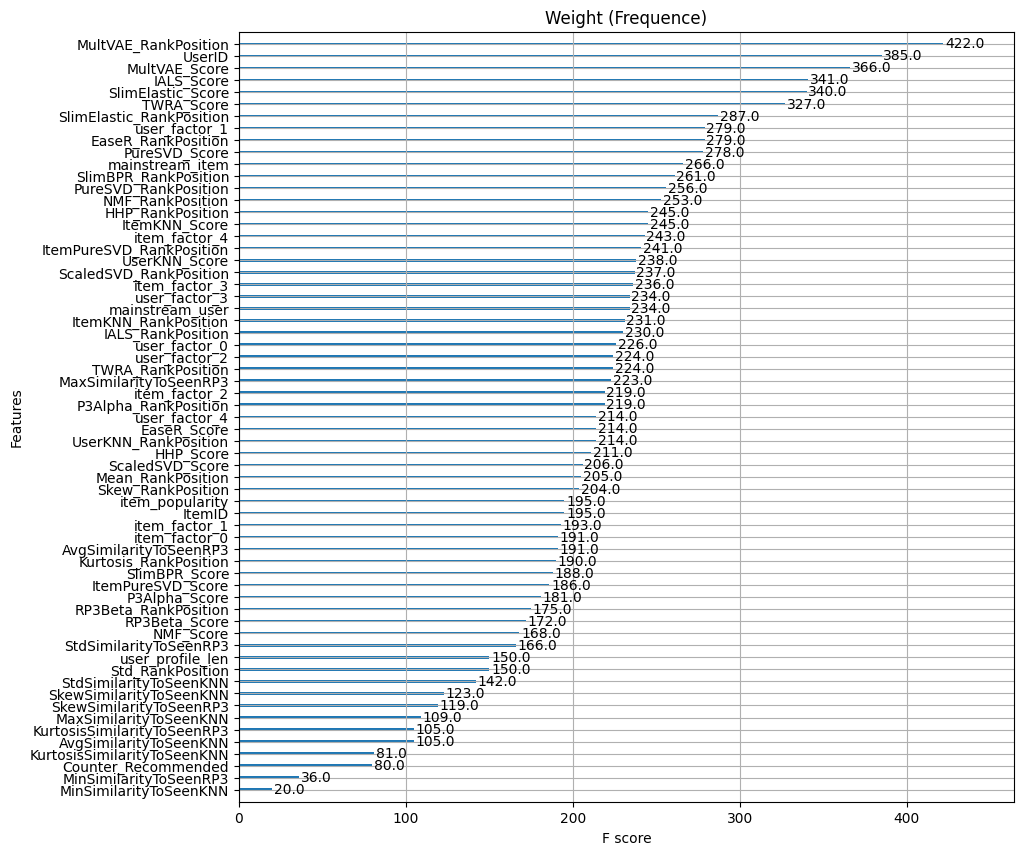

In [47]:
from xgboost import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)', ax=ax)

In [48]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train_complete)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train_complete)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train_complete)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train_complete)
recommender_item_recall.fit(**params_item_knn)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 994.77 column/sec. Elapsed time 22.46 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 646.91 column/sec. Elapsed time 20.13 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2437.53 column/sec. Elapsed time 9.17 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity colum

In [49]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [50]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.auto.tqdm(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        validation_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        validation_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        validation_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()
    
validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in validation_dataframe.columns if col.endswith('_Recommended')]
validation_dataframe['Counter_Recommended'] = validation_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in validation_dataframe.columns if col.endswith('_RankPosition')]
validation_dataframe['Mean_RankPosition'] = validation_dataframe[position_columns].mean(axis=1)
validation_dataframe['Std_RankPosition'] = validation_dataframe[position_columns].std(axis=1)
validation_dataframe['Skew_RankPosition'] = validation_dataframe[position_columns].skew(axis=1)
validation_dataframe['Kurtosis_RankPosition'] = validation_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len
0,0,0,0.000000,22282.0,0.0,0.049929,89.0,0.0,0.000000,22283.0,...,0.000000,NaN,NaN,0,9159.733333,11032.832362,0.438399,-2.085606,0.886121,0.032075
1,0,1,0.000000,7496.0,0.0,0.090336,15.0,0.0,0.000000,7477.0,...,0.000000,NaN,NaN,0,2885.533333,3500.524897,0.552639,-1.858000,1.000000,0.032075
2,0,2,0.000000,7497.0,0.0,0.095367,13.0,0.0,0.000000,7478.0,...,0.000000,NaN,NaN,1,6237.200000,6386.991961,0.997736,1.376638,0.811388,0.032075
3,0,3,0.000000,7498.0,0.0,0.114379,6.0,1.0,0.000000,7479.0,...,0.000000,NaN,NaN,1,4538.400000,5393.310510,1.002640,0.535225,0.973665,0.032075
4,0,7,0.189751,24.0,0.0,0.075345,28.0,0.0,0.113997,12.0,...,0.000000,NaN,NaN,1,1602.266667,4587.660351,3.231414,10.713869,0.692527,0.032075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160066,13023,11955,0.260745,15.0,0.0,0.157063,126.0,0.0,0.138857,32.0,...,0.014879,2.872438,6.805297,0,194.400000,377.901310,2.745088,7.325771,0.004982,0.056604
1160067,13023,13474,0.133842,40.0,0.0,0.080531,372.0,0.0,0.038993,120.0,...,0.009683,3.538551,10.568274,0,1669.466667,4544.358730,3.719477,14.095626,0.005694,0.056604
1160068,13023,13592,0.324246,9.0,1.0,0.085230,341.0,0.0,0.202384,18.0,...,0.018326,2.426400,4.940655,1,440.533333,607.933839,1.493349,1.746023,0.003559,0.056604
1160069,13023,20107,0.117283,44.0,0.0,0.055870,770.0,0.0,0.000000,15603.0,...,0.010866,2.507360,5.053177,0,1787.600000,3916.080508,3.576874,13.279206,0.002847,0.056604


In [51]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])
validation_dataframe = validation_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe = validation_dataframe.sort_values(by='UserID')

validation_dataframe

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,0.000000,22282.0,0.0,0.049929,89.0,0.0,0.000000,22283.0,...,0.163921,0.090707,-0.216788,-0.041741,0.056197,0.005684,-0.001896,0.008995,-0.013853,-0.002147
61,0,1421,0.315619,13.0,0.0,0.038471,136.0,0.0,0.113535,13.0,...,0.008304,-0.000813,0.007862,-0.005303,0.004007,0.005684,-0.001896,0.008995,-0.013853,-0.002147
60,0,1337,0.256143,15.0,0.0,0.024642,334.0,0.0,0.077940,33.0,...,0.007159,-0.012959,0.016733,0.007981,0.040655,0.005684,-0.001896,0.008995,-0.013853,-0.002147
58,0,1213,0.219015,17.0,0.0,0.035522,166.0,0.0,0.086829,25.0,...,0.007796,-0.009614,0.002953,-0.000483,-0.004862,0.005684,-0.001896,0.008995,-0.013853,-0.002147
57,0,1131,0.134693,40.0,0.0,0.000000,9769.0,0.0,0.000000,7813.0,...,0.008328,-0.008771,0.024645,0.012543,0.037796,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160027,13023,695,0.000000,7231.0,0.0,0.357792,15.0,0.0,0.000000,7257.0,...,0.011910,-0.020622,0.017123,0.012590,0.042566,0.006896,-0.007143,0.001571,0.006195,0.023549
1160024,13023,562,0.000000,7107.0,0.0,0.320286,22.0,0.0,0.000000,7304.0,...,0.016861,-0.024979,0.033671,0.028157,0.060212,0.006896,-0.007143,0.001571,0.006195,0.023549
1160023,13023,473,0.119352,43.0,0.0,0.335018,20.0,0.0,0.062268,69.0,...,0.018639,-0.017509,0.038689,0.037094,0.052088,0.006896,-0.007143,0.001571,0.006195,0.023549
1160040,13023,1775,0.522397,2.0,1.0,0.408252,5.0,1.0,0.584994,2.0,...,0.008148,-0.024127,0.008053,0.003610,0.029769,0.006896,-0.007143,0.001571,0.006195,0.023549


In [52]:
# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

# object_columns = validation_dataframe.select_dtypes(include=['object']).columns
# validation_dataframe[object_columns] = validation_dataframe[object_columns].astype('category')

In [53]:
class XGBoostRerankerRecommender:
    def __init__(self, URM_train, XGB_model, df):
        self.URM_train = URM_train
        self.df = df
        self.XGB_model = XGB_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.XGB_model.predict(df_slice)
            recommendations.append(items[np.argsort(preds)[-cutoff:][::-1]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [54]:
recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 4.07 min. Users per second: 43


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.099254,0.171013,0.144124,0.049476,0.082606,0.269937,0.152036,0.117553,0.534143,0.360547,...,0.802826,0.428824,0.802826,0.055016,10.053627,0.996868,0.158743,0.774492,2.069991,0.293584


In [55]:
def objective_xgboost(trial):

    XGB_model = XGBRanker(
        objective = trial.suggest_categorical('objective', ["rank:map", "rank:pairwise", "rank:ndcg"]),
        n_estimators = trial.suggest_int('n_estimators', 10, 5000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 20),
        max_leaves = trial.suggest_int('max_leaves', 8, 1024),
        grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        verbosity = 2,
        booster = 'gbtree',
        # tree_method = trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        tree_method = 'hist',
        gamma = trial.suggest_float('gamma', 1e-7, 10, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-7, 1, log=True),
        subsample = trial.suggest_float('subsample', 0.1, 0.9),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9),
        # enable_categorical = True
    )
    
    XGB_model.fit(
        X_train,
        y_train,
        group=groups,
        verbose=True
    )
    
    recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
        
    return result_df.loc[10, 'MAP']

In [56]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_xgboost.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [57]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='xgboost_tuning_fixed_more_recommenders_more_candidates', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=config['n_trials'])

[I 2023-12-26 18:22:33,901] A new study created in RDB with name: xgboost_tuning_fixed_more_recommenders_more_candidates


EvaluatorHoldout: Processed 10456 (100.0%) in 4.25 min. Users per second: 41


[I 2023-12-26 18:31:25,449] Trial 0 finished with value: 0.03133161562890928 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 885, 'learning_rate': 0.4051757431629611, 'reg_alpha': 0.06448972512421454, 'reg_lambda': 2.3651434215908266e-05, 'max_depth': 5, 'max_leaves': 574, 'grow_policy': 'depthwise', 'gamma': 2.077101469600172e-07, 'min_child_weight': 0.004841041588715316, 'subsample': 0.853798436422326, 'colsample_bytree': 0.500869241966458}. Best is trial 0 with value: 0.03133161562890928.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.85 min. Users per second: 45


[I 2023-12-26 18:35:37,088] Trial 1 finished with value: 0.04248242825566885 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 10, 'learning_rate': 0.07131543695227618, 'reg_alpha': 0.00018092503559183722, 'reg_lambda': 0.007679784117563551, 'max_depth': 15, 'max_leaves': 860, 'grow_policy': 'depthwise', 'gamma': 9.102701316587883e-06, 'min_child_weight': 0.4134554083550639, 'subsample': 0.3199494391597284, 'colsample_bytree': 0.11231553930440202}. Best is trial 1 with value: 0.04248242825566885.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.91 min. Users per second: 45


[I 2023-12-26 18:40:34,916] Trial 2 finished with value: 0.05138288489330988 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 89, 'learning_rate': 0.0029666288494647436, 'reg_alpha': 0.34951854378008085, 'reg_lambda': 1.5650818221550136e-05, 'max_depth': 10, 'max_leaves': 296, 'grow_policy': 'depthwise', 'gamma': 2.5104652079872865, 'min_child_weight': 0.0010636030012810761, 'subsample': 0.35801269071343866, 'colsample_bytree': 0.44855280095447647}. Best is trial 2 with value: 0.05138288489330988.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.91 min. Users per second: 45


[I 2023-12-26 18:45:29,255] Trial 3 finished with value: 0.05088353614845623 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 128, 'learning_rate': 0.07949919677666432, 'reg_alpha': 0.001955423067657304, 'reg_lambda': 0.016936536226016662, 'max_depth': 6, 'max_leaves': 867, 'grow_policy': 'lossguide', 'gamma': 1.5255409599617426e-05, 'min_child_weight': 0.0016692266828530228, 'subsample': 0.34661347314306934, 'colsample_bytree': 0.20051275443613356}. Best is trial 2 with value: 0.05138288489330988.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.85 min. Users per second: 45


[I 2023-12-26 18:49:41,421] Trial 4 finished with value: 0.0473400022467547 and parameters: {'objective': 'rank:map', 'n_estimators': 13, 'learning_rate': 0.12486408957693292, 'reg_alpha': 0.0001425430774461635, 'reg_lambda': 0.047524618203841414, 'max_depth': 10, 'max_leaves': 299, 'grow_policy': 'depthwise', 'gamma': 1.4199338764028711e-06, 'min_child_weight': 9.289625934687623e-07, 'subsample': 0.7311423265292207, 'colsample_bytree': 0.23096373456324573}. Best is trial 2 with value: 0.05138288489330988.


EvaluatorHoldout: Processed 6000 (57.4%) in 5.96 min. Users per second: 17
EvaluatorHoldout: Processed 10456 (100.0%) in 10.38 min. Users per second: 17


[I 2023-12-26 19:40:26,856] Trial 5 finished with value: 0.0487384739983732 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2558, 'learning_rate': 0.02543354187579539, 'reg_alpha': 0.8016759410869081, 'reg_lambda': 0.000888621993625596, 'max_depth': 19, 'max_leaves': 618, 'grow_policy': 'lossguide', 'gamma': 8.170888981538006e-07, 'min_child_weight': 1.032061313641886e-06, 'subsample': 0.8733340941841189, 'colsample_bytree': 0.7687983875538253}. Best is trial 2 with value: 0.05138288489330988.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.10 min. Users per second: 42


[I 2023-12-26 19:47:01,131] Trial 6 finished with value: 0.05062069625095674 and parameters: {'objective': 'rank:map', 'n_estimators': 255, 'learning_rate': 0.017268912914832287, 'reg_alpha': 0.10280885920675825, 'reg_lambda': 0.00030628776727633684, 'max_depth': 8, 'max_leaves': 868, 'grow_policy': 'lossguide', 'gamma': 0.5384924502941709, 'min_child_weight': 2.339737693687011e-05, 'subsample': 0.6350792398651876, 'colsample_bytree': 0.6765603556624086}. Best is trial 2 with value: 0.05138288489330988.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.84 min. Users per second: 45


[I 2023-12-26 19:51:27,498] Trial 7 finished with value: 0.049346649907094114 and parameters: {'objective': 'rank:map', 'n_estimators': 37, 'learning_rate': 0.0019385496152616653, 'reg_alpha': 0.05749243199797467, 'reg_lambda': 0.00016051666228131083, 'max_depth': 9, 'max_leaves': 606, 'grow_policy': 'depthwise', 'gamma': 1.7332986200079774e-06, 'min_child_weight': 1.5251696642037832e-07, 'subsample': 0.4971864305364676, 'colsample_bytree': 0.7358225603691152}. Best is trial 2 with value: 0.05138288489330988.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.96 min. Users per second: 44


[I 2023-12-26 19:56:44,789] Trial 8 finished with value: 0.05208606207721606 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 100, 'learning_rate': 0.0036645087454132883, 'reg_alpha': 0.001994013853677025, 'reg_lambda': 4.9871255913630596e-05, 'max_depth': 12, 'max_leaves': 286, 'grow_policy': 'lossguide', 'gamma': 2.3571036287943701e-07, 'min_child_weight': 0.7672935989693686, 'subsample': 0.32335035533435597, 'colsample_bytree': 0.7373851395749078}. Best is trial 8 with value: 0.05208606207721606.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.54 min. Users per second: 38


[I 2023-12-26 20:04:58,112] Trial 9 finished with value: 0.05087585847269332 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 273, 'learning_rate': 0.0003078865887454108, 'reg_alpha': 5.0898363784227723e-05, 'reg_lambda': 1.0689741701006116e-05, 'max_depth': 12, 'max_leaves': 443, 'grow_policy': 'lossguide', 'gamma': 0.0013410444759574373, 'min_child_weight': 0.000391871528338805, 'subsample': 0.27780447379908707, 'colsample_bytree': 0.61654173349126}. Best is trial 8 with value: 0.05208606207721606.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.84 min. Users per second: 45


[I 2023-12-26 20:09:20,940] Trial 10 finished with value: 0.051193288428608506 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 48, 'learning_rate': 0.000192953440989422, 'reg_alpha': 0.0024022008084561342, 'reg_lambda': 0.47585064052623793, 'max_depth': 15, 'max_leaves': 25, 'grow_policy': 'lossguide', 'gamma': 0.000245900990792182, 'min_child_weight': 0.5843590602401754, 'subsample': 0.13188189528317218, 'colsample_bytree': 0.8702457354970625}. Best is trial 8 with value: 0.05208606207721606.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.93 min. Users per second: 44


[I 2023-12-26 20:14:16,412] Trial 11 finished with value: 0.052053317150630156 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 86, 'learning_rate': 0.0027195875033299254, 'reg_alpha': 0.006092340787172617, 'reg_lambda': 5.4895504135714106e-05, 'max_depth': 13, 'max_leaves': 186, 'grow_policy': 'depthwise', 'gamma': 8.08866473044021, 'min_child_weight': 0.03314455765492209, 'subsample': 0.46886163084605875, 'colsample_bytree': 0.4153996718551687}. Best is trial 8 with value: 0.05208606207721606.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.95 min. Users per second: 44


[I 2023-12-26 20:20:13,911] Trial 12 finished with value: 0.05192348359262143 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 304, 'learning_rate': 0.001668752981962086, 'reg_alpha': 0.011040937349748656, 'reg_lambda': 0.00019703198277598778, 'max_depth': 14, 'max_leaves': 29, 'grow_policy': 'depthwise', 'gamma': 0.06978079602196971, 'min_child_weight': 0.04126247623099269, 'subsample': 0.48469086519194426, 'colsample_bytree': 0.42859106536031505}. Best is trial 8 with value: 0.05208606207721606.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.94 min. Users per second: 44


[I 2023-12-26 20:24:50,831] Trial 13 finished with value: 0.052152386872882685 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 39, 'learning_rate': 0.0071181533310121356, 'reg_alpha': 0.0006676978012004568, 'reg_lambda': 8.25071705223293e-05, 'max_depth': 19, 'max_leaves': 225, 'grow_policy': 'lossguide', 'gamma': 0.016320733509535452, 'min_child_weight': 0.039386086467624815, 'subsample': 0.544718725546756, 'colsample_bytree': 0.886987403425558}. Best is trial 13 with value: 0.052152386872882685.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.87 min. Users per second: 45


[I 2023-12-26 20:29:11,337] Trial 14 finished with value: 0.051899801587302105 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 22, 'learning_rate': 0.006791844525749913, 'reg_alpha': 1.0802060063547036e-05, 'reg_lambda': 0.0011514019400864935, 'max_depth': 20, 'max_leaves': 212, 'grow_policy': 'lossguide', 'gamma': 0.009611834050878945, 'min_child_weight': 0.809014463375917, 'subsample': 0.6050563329900491, 'colsample_bytree': 0.8942018586197598}. Best is trial 13 with value: 0.052152386872882685.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.88 min. Users per second: 45


[I 2023-12-26 20:33:46,771] Trial 15 finished with value: 0.05138651689316426 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 33, 'learning_rate': 0.0005756434105676439, 'reg_alpha': 0.0006002009432474387, 'reg_lambda': 5.489828313651184e-05, 'max_depth': 17, 'max_leaves': 432, 'grow_policy': 'lossguide', 'gamma': 0.00015766829647112447, 'min_child_weight': 0.04648826730017176, 'subsample': 0.19404650058956951, 'colsample_bytree': 0.8088438265887802}. Best is trial 13 with value: 0.052152386872882685.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.90 min. Users per second: 45


[I 2023-12-26 20:38:28,453] Trial 16 finished with value: 0.05195311266562283 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 55, 'learning_rate': 0.01006678196257175, 'reg_alpha': 0.0008884198552993452, 'reg_lambda': 7.6045672090076e-05, 'max_depth': 17, 'max_leaves': 168, 'grow_policy': 'lossguide', 'gamma': 0.0027321703148110127, 'min_child_weight': 0.1055142332195886, 'subsample': 0.4168873134544065, 'colsample_bytree': 0.8910639330071167}. Best is trial 13 with value: 0.052152386872882685.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.77 min. Users per second: 46


[I 2023-12-26 20:42:32,641] Trial 17 finished with value: 0.050524708225550455 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 17, 'learning_rate': 0.00010814154651909949, 'reg_alpha': 0.01099626362939531, 'reg_lambda': 0.0006810119784500106, 'max_depth': 3, 'max_leaves': 375, 'grow_policy': 'lossguide', 'gamma': 0.04307076235729607, 'min_child_weight': 0.010829409265047024, 'subsample': 0.5636621092271453, 'colsample_bytree': 0.7923755108883443}. Best is trial 13 with value: 0.052152386872882685.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.23 min. Users per second: 41


[I 2023-12-26 20:49:12,270] Trial 18 finished with value: 0.049327605627816594 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 143, 'learning_rate': 0.006552465726414231, 'reg_alpha': 0.0006465902862975059, 'reg_lambda': 0.0024249655792305674, 'max_depth': 18, 'max_leaves': 712, 'grow_policy': 'lossguide', 'gamma': 0.0001298823647744062, 'min_child_weight': 0.20842886035111743, 'subsample': 0.24908171266966084, 'colsample_bytree': 0.661144696932795}. Best is trial 13 with value: 0.052152386872882685.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.83 min. Users per second: 45


[I 2023-12-26 20:53:25,927] Trial 19 finished with value: 0.049176852965109 and parameters: {'objective': 'rank:map', 'n_estimators': 20, 'learning_rate': 0.0012613634449757918, 'reg_alpha': 0.003567694360755095, 'reg_lambda': 1.0070199270308427e-05, 'max_depth': 16, 'max_leaves': 97, 'grow_policy': 'lossguide', 'gamma': 1.1286608121434791e-07, 'min_child_weight': 0.9327356697293079, 'subsample': 0.43070988411957783, 'colsample_bytree': 0.7239207649729381}. Best is trial 13 with value: 0.052152386872882685.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.00 min. Users per second: 44


[I 2023-12-26 20:58:56,894] Trial 20 finished with value: 0.048988896023852764 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 66, 'learning_rate': 0.0009079709076941154, 'reg_alpha': 0.024901406714821266, 'reg_lambda': 0.0002904688234596098, 'max_depth': 20, 'max_leaves': 1011, 'grow_policy': 'lossguide', 'gamma': 2.7299632413527027e-05, 'min_child_weight': 0.012801657908411779, 'subsample': 0.10425265720206034, 'colsample_bytree': 0.8047873640183424}. Best is trial 13 with value: 0.052152386872882685.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.01 min. Users per second: 43


[I 2023-12-26 21:04:07,163] Trial 21 finished with value: 0.052076942228052155 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 100, 'learning_rate': 0.003993324861158908, 'reg_alpha': 0.00627944032189499, 'reg_lambda': 5.9272566933318065e-05, 'max_depth': 13, 'max_leaves': 213, 'grow_policy': 'depthwise', 'gamma': 8.414643686273658, 'min_child_weight': 0.0829760750967423, 'subsample': 0.42279879461777137, 'colsample_bytree': 0.5416194848462924}. Best is trial 13 with value: 0.052152386872882685.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.89 min. Users per second: 45


[I 2023-12-26 21:08:29,655] Trial 22 finished with value: 0.05017743287062406 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 28, 'learning_rate': 0.004279150051562878, 'reg_alpha': 0.001917914907032278, 'reg_lambda': 3.35264414485744e-05, 'max_depth': 12, 'max_leaves': 315, 'grow_policy': 'depthwise', 'gamma': 0.4576507986688709, 'min_child_weight': 0.12051924209451559, 'subsample': 0.3853794056181376, 'colsample_bytree': 0.5960148486362027}. Best is trial 13 with value: 0.052152386872882685.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.91 min. Users per second: 45


[I 2023-12-26 21:13:42,202] Trial 23 finished with value: 0.05197943233018818 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 146, 'learning_rate': 0.003464437928784163, 'reg_alpha': 0.006585481021217387, 'reg_lambda': 0.00011348154052184893, 'max_depth': 7, 'max_leaves': 231, 'grow_policy': 'depthwise', 'gamma': 0.008130900163255853, 'min_child_weight': 0.15764388660710982, 'subsample': 0.5459559235480416, 'colsample_bytree': 0.8339608886799957}. Best is trial 13 with value: 0.052152386872882685.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.89 min. Users per second: 45


[I 2023-12-26 21:18:14,563] Trial 24 finished with value: 0.05214047376155303 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 48, 'learning_rate': 0.00849866768315009, 'reg_alpha': 0.018968200568390055, 'reg_lambda': 3.270071472415169e-05, 'max_depth': 13, 'max_leaves': 114, 'grow_policy': 'lossguide', 'gamma': 0.0004471650700599369, 'min_child_weight': 0.0150975869307753, 'subsample': 0.3007165933448342, 'colsample_bytree': 0.7386757618268179}. Best is trial 13 with value: 0.052152386872882685.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.88 min. Users per second: 45


[I 2023-12-26 21:22:41,576] Trial 25 finished with value: 0.05216156744513719 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 45, 'learning_rate': 0.013478271295637419, 'reg_alpha': 0.0239550440840429, 'reg_lambda': 2.631130155100178e-05, 'max_depth': 10, 'max_leaves': 80, 'grow_policy': 'lossguide', 'gamma': 0.000907999312520856, 'min_child_weight': 0.011453123352130343, 'subsample': 0.2881226248966004, 'colsample_bytree': 0.7261697305436069}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.93 min. Users per second: 44


[I 2023-12-26 21:27:16,579] Trial 26 finished with value: 0.05181005665464398 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 52, 'learning_rate': 0.018134835507077174, 'reg_alpha': 0.023150294666913027, 'reg_lambda': 2.441557937990097e-05, 'max_depth': 10, 'max_leaves': 104, 'grow_policy': 'lossguide', 'gamma': 0.0006990889150670954, 'min_child_weight': 0.0054855473410846305, 'subsample': 0.21346606093944545, 'colsample_bytree': 0.8192676579395112}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.83 min. Users per second: 45


[I 2023-12-26 21:31:35,450] Trial 27 finished with value: 0.051945829689948625 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 31, 'learning_rate': 0.010898773073628961, 'reg_alpha': 0.021560874624179254, 'reg_lambda': 2.9300992248747238e-05, 'max_depth': 11, 'max_leaves': 102, 'grow_policy': 'lossguide', 'gamma': 0.0005693983215046125, 'min_child_weight': 0.0265760149190594, 'subsample': 0.2791993948042088, 'colsample_bytree': 0.8518782372199614}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.86 min. Users per second: 45


[I 2023-12-26 21:35:45,061] Trial 28 finished with value: 0.05148188630208558 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 15, 'learning_rate': 0.01964113075712588, 'reg_alpha': 0.16141096339429845, 'reg_lambda': 0.00011822917916788236, 'max_depth': 4, 'max_leaves': 19, 'grow_policy': 'lossguide', 'gamma': 0.006442704577557912, 'min_child_weight': 0.00263491933069309, 'subsample': 0.1905946256728972, 'colsample_bytree': 0.6843126161009108}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.88 min. Users per second: 45


[I 2023-12-26 21:40:09,831] Trial 29 finished with value: 0.05122975264449121 and parameters: {'objective': 'rank:map', 'n_estimators': 44, 'learning_rate': 0.03274129839774808, 'reg_alpha': 0.04583927424723187, 'reg_lambda': 1.9661390392963098e-05, 'max_depth': 6, 'max_leaves': 129, 'grow_policy': 'lossguide', 'gamma': 0.003320593731475074, 'min_child_weight': 0.005355885452250704, 'subsample': 0.37991165606924465, 'colsample_bytree': 0.7671576402111365}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.81 min. Users per second: 46


[I 2023-12-26 21:44:21,273] Trial 30 finished with value: 0.04494920513474505 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 22, 'learning_rate': 0.4778647156059975, 'reg_alpha': 0.14166089310732022, 'reg_lambda': 2.3752918324657734e-05, 'max_depth': 8, 'max_leaves': 524, 'grow_policy': 'lossguide', 'gamma': 5.707295048580692e-05, 'min_child_weight': 0.015591668937749104, 'subsample': 0.30980487542528634, 'colsample_bytree': 0.8471455020787746}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.93 min. Users per second: 44


[I 2023-12-26 21:49:14,538] Trial 31 finished with value: 0.04958002772009143 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 67, 'learning_rate': 0.007591918620579405, 'reg_alpha': 0.0013138820352244117, 'reg_lambda': 4.269706897823823e-05, 'max_depth': 11, 'max_leaves': 374, 'grow_policy': 'lossguide', 'gamma': 1.0660263293422627e-07, 'min_child_weight': 0.27078996974464314, 'subsample': 0.30125856495158515, 'colsample_bytree': 0.7515964949416127}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.91 min. Users per second: 45


[I 2023-12-26 21:53:47,070] Trial 32 finished with value: 0.051958319670638485 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 37, 'learning_rate': 0.005486743481296857, 'reg_alpha': 0.004696853055079156, 'reg_lambda': 9.134988994528674e-05, 'max_depth': 14, 'max_leaves': 262, 'grow_policy': 'lossguide', 'gamma': 5.188306159907534e-05, 'min_child_weight': 0.24080569133860985, 'subsample': 0.32759557469924705, 'colsample_bytree': 0.7058230016958298}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.98 min. Users per second: 44


[I 2023-12-26 21:58:05,111] Trial 33 finished with value: 0.051618501870271866 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 10, 'learning_rate': 0.011644063915292888, 'reg_alpha': 0.00036639467057275285, 'reg_lambda': 1.4601620970288092e-05, 'max_depth': 13, 'max_leaves': 146, 'grow_policy': 'lossguide', 'gamma': 2.6076732955604803e-06, 'min_child_weight': 0.06705176241121459, 'subsample': 0.24956702322099142, 'colsample_bytree': 0.7408402419074492}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.95 min. Users per second: 44


[I 2023-12-26 22:02:43,428] Trial 34 finished with value: 0.05196847560753491 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 66, 'learning_rate': 0.04134806462742465, 'reg_alpha': 0.0026691451885988435, 'reg_lambda': 0.00036557731738907613, 'max_depth': 9, 'max_leaves': 64, 'grow_policy': 'lossguide', 'gamma': 3.715490994052628e-07, 'min_child_weight': 0.35034898760678423, 'subsample': 0.34830362650919194, 'colsample_bytree': 0.8982945559817084}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.88 min. Users per second: 45


[I 2023-12-26 22:07:10,886] Trial 35 finished with value: 0.048911398179522315 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 26, 'learning_rate': 0.0024451402678770775, 'reg_alpha': 0.0012301786514785774, 'reg_lambda': 3.7455304354367304e-05, 'max_depth': 15, 'max_leaves': 362, 'grow_policy': 'lossguide', 'gamma': 6.425265668763097e-06, 'min_child_weight': 0.0008419810768681877, 'subsample': 0.36952854897090326, 'colsample_bytree': 0.6323983697102025}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.12 min. Users per second: 42


[I 2023-12-26 22:13:20,046] Trial 36 finished with value: 0.05150107479870342 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 174, 'learning_rate': 0.005128330644995003, 'reg_alpha': 0.011427615825618746, 'reg_lambda': 0.00012378261937124764, 'max_depth': 11, 'max_leaves': 271, 'grow_policy': 'lossguide', 'gamma': 1.0496066143219185e-05, 'min_child_weight': 0.0034378284046080823, 'subsample': 0.4480646496891696, 'colsample_bytree': 0.7798813056632712}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.93 min. Users per second: 44


[I 2023-12-26 22:18:22,883] Trial 37 finished with value: 0.05181055762014118 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 108, 'learning_rate': 0.013564149435466164, 'reg_alpha': 0.00028381468837846015, 'reg_lambda': 1.539906912907108e-05, 'max_depth': 9, 'max_leaves': 154, 'grow_policy': 'lossguide', 'gamma': 4.391133359876483e-06, 'min_child_weight': 0.01666093535076781, 'subsample': 0.33349385265012726, 'colsample_bytree': 0.7040826356313336}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.00 min. Users per second: 44


[I 2023-12-26 22:23:29,148] Trial 38 finished with value: 0.04870662853256629 and parameters: {'objective': 'rank:map', 'n_estimators': 79, 'learning_rate': 0.04148659210820373, 'reg_alpha': 0.04529128080588212, 'reg_lambda': 7.261795746348365e-05, 'max_depth': 10, 'max_leaves': 312, 'grow_policy': 'lossguide', 'gamma': 5.296393913978102e-07, 'min_child_weight': 0.007491985599406056, 'subsample': 0.5287694142661529, 'colsample_bytree': 0.8459164552031971}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.89 min. Users per second: 45


[I 2023-12-26 22:27:43,257] Trial 39 finished with value: 0.05062163745886047 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 15, 'learning_rate': 0.008421448379266993, 'reg_alpha': 0.0017068828036577851, 'reg_lambda': 0.00021280851076625258, 'max_depth': 18, 'max_leaves': 71, 'grow_policy': 'lossguide', 'gamma': 1.107152945080083e-06, 'min_child_weight': 0.0010865794308350823, 'subsample': 0.7152019252349541, 'colsample_bytree': 0.7734526080885267}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.95 min. Users per second: 44


[I 2023-12-26 22:32:25,004] Trial 40 finished with value: 0.04379440375997419 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 43, 'learning_rate': 0.08063591690869264, 'reg_alpha': 0.003371411470958946, 'reg_lambda': 2.22153597736456e-05, 'max_depth': 14, 'max_leaves': 446, 'grow_policy': 'lossguide', 'gamma': 1.6164890101143277e-05, 'min_child_weight': 0.5201210702783797, 'subsample': 0.39780327088287676, 'colsample_bytree': 0.7242736822321152}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.94 min. Users per second: 44


[I 2023-12-26 22:37:30,547] Trial 41 finished with value: 0.051442048159483535 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 105, 'learning_rate': 0.004120238292475513, 'reg_alpha': 0.006902715254951614, 'reg_lambda': 4.412253724092981e-05, 'max_depth': 13, 'max_leaves': 222, 'grow_policy': 'depthwise', 'gamma': 0.00039272994526406925, 'min_child_weight': 0.08116374223733269, 'subsample': 0.43958787843339364, 'colsample_bytree': 0.567428621113289}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.94 min. Users per second: 44


[I 2023-12-26 22:42:34,140] Trial 42 finished with value: 0.05178427211231386 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 107, 'learning_rate': 0.0034802081785670655, 'reg_alpha': 0.0031757320537687565, 'reg_lambda': 5.244846548786848e-05, 'max_depth': 12, 'max_leaves': 176, 'grow_policy': 'depthwise', 'gamma': 1.3611728676979078, 'min_child_weight': 0.02871631007876261, 'subsample': 0.41001420769529234, 'colsample_bytree': 0.5433730961965969}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.94 min. Users per second: 44


[I 2023-12-26 22:47:27,842] Trial 43 finished with value: 0.05123029535711305 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 81, 'learning_rate': 0.002679418687868373, 'reg_alpha': 0.015268754675548455, 'reg_lambda': 8.158205121537152e-05, 'max_depth': 16, 'max_leaves': 253, 'grow_policy': 'depthwise', 'gamma': 0.02468780068526776, 'min_child_weight': 0.09388668978893526, 'subsample': 0.35270236988646875, 'colsample_bytree': 0.6657442064840321}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.15 min. Users per second: 42


[I 2023-12-26 22:53:48,609] Trial 44 finished with value: 0.049360259469766354 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 210, 'learning_rate': 0.005511350333955406, 'reg_alpha': 0.006564410933514968, 'reg_lambda': 1.01077080284745e-05, 'max_depth': 13, 'max_leaves': 331, 'grow_policy': 'depthwise', 'gamma': 0.0015627235585616496, 'min_child_weight': 0.05318015604229336, 'subsample': 0.5036739799441867, 'colsample_bytree': 0.5197172839008898}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.87 min. Users per second: 45


[I 2023-12-26 22:58:18,323] Trial 45 finished with value: 0.05148958674900771 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 51, 'learning_rate': 0.0020200262896018627, 'reg_alpha': 0.02839993296128626, 'reg_lambda': 0.00018675307922333065, 'max_depth': 8, 'max_leaves': 213, 'grow_policy': 'depthwise', 'gamma': 0.226653325657336, 'min_child_weight': 0.41851114240397386, 'subsample': 0.29849104148353417, 'colsample_bytree': 0.6408757743750662}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.02 min. Users per second: 43


[I 2023-12-26 23:04:45,334] Trial 46 finished with value: 0.051954027307174355 and parameters: {'objective': 'rank:map', 'n_estimators': 348, 'learning_rate': 0.014199068619714247, 'reg_alpha': 0.0647606597465944, 'reg_lambda': 3.0470545009055675e-05, 'max_depth': 11, 'max_leaves': 59, 'grow_policy': 'depthwise', 'gamma': 7.590141983620376, 'min_child_weight': 0.025063723553995377, 'subsample': 0.46588123535554654, 'colsample_bytree': 0.463840730764913}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.96 min. Users per second: 44


[I 2023-12-26 23:09:31,766] Trial 47 finished with value: 0.04821289667358973 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 37, 'learning_rate': 0.008660541416793406, 'reg_alpha': 0.0010524424321503851, 'reg_lambda': 6.861343412613438e-05, 'max_depth': 14, 'max_leaves': 707, 'grow_policy': 'lossguide', 'gamma': 0.0002873885697373875, 'min_child_weight': 0.9587131095013568, 'subsample': 0.35301273434007463, 'colsample_bytree': 0.6070775751827288}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.87 min. Users per second: 45


[I 2023-12-26 23:14:04,945] Trial 48 finished with value: 0.05144110695157982 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 59, 'learning_rate': 0.024650316275379325, 'reg_alpha': 0.010083817528623699, 'reg_lambda': 1.6278224681041427e-05, 'max_depth': 15, 'max_leaves': 144, 'grow_policy': 'depthwise', 'gamma': 0.0010810031633996023, 'min_child_weight': 0.19165508267895698, 'subsample': 0.4054263192796257, 'colsample_bytree': 0.6868448798762634}. Best is trial 25 with value: 0.05216156744513719.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.01 min. Users per second: 43


[I 2023-12-26 23:19:19,712] Trial 49 finished with value: 0.05147159753342863 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 81, 'learning_rate': 0.0035933720254868605, 'reg_alpha': 0.004648598336500951, 'reg_lambda': 0.00013082788319194913, 'max_depth': 12, 'max_leaves': 415, 'grow_policy': 'lossguide', 'gamma': 0.01661836268952926, 'min_child_weight': 0.05356382778007171, 'subsample': 0.4710011090672864, 'colsample_bytree': 0.8009400246499087}. Best is trial 25 with value: 0.05216156744513719.


In [58]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [59]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [60]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [61]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_hybrid_xgboost.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_hybrid_xgboost.json', 
            'tuning_results/best_params_hybrid_xgboost.json', 
            'XGBoost tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/xgboost/best_params_hybrid_xgboost.json', 
        '/kaggle/working/best_params_hybrid_xgboost.json'
    )

In [62]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_xgboost.db', 
        'Xgboost tuning db updated results (from kaggle notebook)'
    )

In [63]:
with open('/kaggle/working/best_params_hybrid_xgboost.json', 'r') as params_file:
    xgboost_params = json.load(params_file)
xgboost_params['tree_method'] = 'hist'
xgboost_params['booster'] = 'gbtree'
xgboost_params

{'objective': 'rank:pairwise',
 'n_estimators': 45,
 'learning_rate': 0.013478271295637419,
 'reg_alpha': 0.0239550440840429,
 'reg_lambda': 2.631130155100178e-05,
 'max_depth': 10,
 'max_leaves': 80,
 'grow_policy': 'lossguide',
 'gamma': 0.000907999312520856,
 'min_child_weight': 0.011453123352130343,
 'subsample': 0.2881226248966004,
 'colsample_bytree': 0.7261697305436069,
 'tree_method': 'hist',
 'booster': 'gbtree'}

In [64]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_final_train = recommender_pure_svd.USER_factors
item_factors_final_train = recommender_pure_svd.ITEM_factors

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train_complete)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train_complete)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_all)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_all)
recommender_item_recall.fit(**params_item_knn)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1089.04 column/sec. Elapsed time 20.52 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 634.42 column/sec. Elapsed time 20.53 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2425.66 column/sec. Elapsed time 9.21 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity colu

In [65]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [66]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = final_train_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        final_train_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        final_train_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        final_train_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in final_train_dataframe.columns if col.endswith('_Recommended')]
final_train_dataframe['Counter_Recommended'] = final_train_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in final_train_dataframe.columns if col.endswith('_RankPosition')]
final_train_dataframe['Mean_RankPosition'] = final_train_dataframe[position_columns].mean(axis=1)
final_train_dataframe['Std_RankPosition'] = final_train_dataframe[position_columns].std(axis=1)
final_train_dataframe['Skew_RankPosition'] = final_train_dataframe[position_columns].skew(axis=1)
final_train_dataframe['Kurtosis_RankPosition'] = final_train_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
final_train_dataframe['mainstream_item'] = mainstream_item[final_train_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

final_train_dataframe = final_train_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe = final_train_dataframe.sort_values(by='UserID')
final_train_dataframe

/tmp/ipykernel_19/4000761057.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,False,0.000000,22282.0,0.0,0.049929,89.0,0.0,0.000000,...,0.161283,0.057150,-0.179319,-0.017929,0.058489,0.005573,0.000276,0.007794,-0.010626,-0.001530
59,0,1067,False,0.000000,8333.0,0.0,0.031917,206.0,0.0,0.038447,...,0.006633,0.003640,0.012813,-0.006771,0.000972,0.005573,0.000276,0.007794,-0.010626,-0.001530
58,0,1056,False,0.163821,30.0,0.0,0.006996,2925.0,0.0,0.095042,...,0.002581,-0.001164,0.000103,-0.001671,0.001920,0.005573,0.000276,0.007794,-0.010626,-0.001530
57,0,1012,False,0.192977,23.0,0.0,0.022158,405.0,0.0,0.061345,...,0.011549,0.009009,0.010606,0.013514,-0.004136,0.005573,0.000276,0.007794,-0.010626,-0.001530
56,0,976,False,0.181312,26.0,0.0,0.146001,3.0,1.0,0.000000,...,0.007626,-0.001412,0.009353,-0.007804,0.000635,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221458,13023,562,False,0.000000,7107.0,0.0,0.320286,22.0,0.0,0.000000,...,0.016208,-0.027309,0.038131,0.034664,0.064509,0.009693,-0.007923,-0.000422,0.004503,0.023066
1221453,13023,407,False,0.000000,7180.0,0.0,0.248697,42.0,0.0,0.000000,...,0.020133,-0.039630,0.018026,0.009485,0.061210,0.009693,-0.007923,-0.000422,0.004503,0.023066
1221449,13023,328,False,0.201269,24.0,0.0,0.353888,16.0,0.0,0.136396,...,0.021672,-0.033972,0.021341,0.030813,0.063417,0.009693,-0.007923,-0.000422,0.004503,0.023066
1221446,13023,291,False,0.291368,12.0,0.0,0.416577,4.0,1.0,0.169366,...,0.020738,-0.035437,0.020273,0.028617,0.074795,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [67]:
groups = final_train_dataframe.groupby("UserID").size().values
groups

array([ 82,  74,  97, ..., 110,  73,  73])

In [68]:
XGB_model = XGBRanker(**xgboost_params)

y_train = final_train_dataframe["Label"]
X_train = final_train_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.7261697305436069, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=0.000907999312520856,
          grow_policy='lossguide', importance_type=None,
          interaction_constraints=None, learning_rate=0.013478271295637419,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=10, max_leaves=80,
          min_child_weight=0.011453123352130343, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=45,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

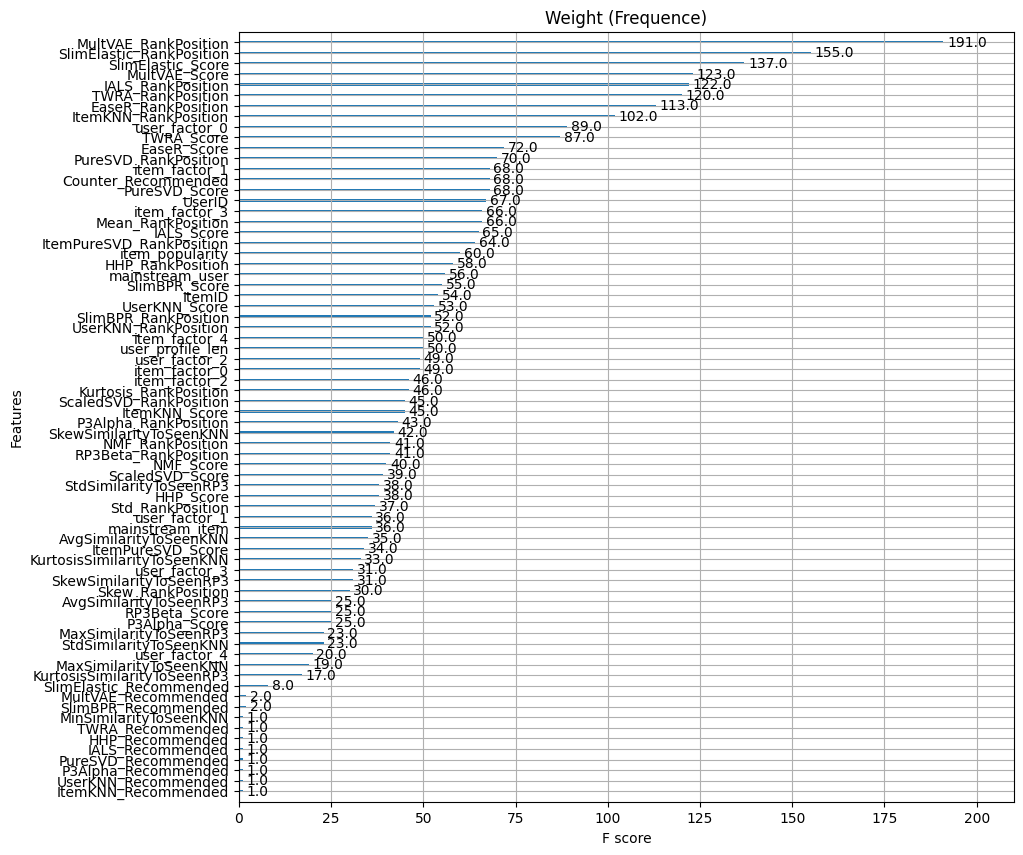

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)', ax=ax)

In [70]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

recommender_vae = MultVAERecommender(URM_all)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_all')

recommender_hhp = HHPRecommender(URM_all)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_all)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_all)
# recommender_als.load_model('/kaggle/working/', 'als_all.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_all)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_all.zip')

recommender_rp3_recall = RP3betaRecommender(URM_all)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_all)
recommender_item_recall.fit(**params_item_knn)

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 984.75 column/sec. Elapsed time 22.69 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 619.17 column/sec. Elapsed time 21.03 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2227.43 column/sec. Elapsed time 10.03 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity colu

In [71]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [72]:
cutoff = 50
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        prediction_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        prediction_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        prediction_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in prediction_dataframe.columns if col.endswith('_Recommended')]
prediction_dataframe['Counter_Recommended'] = prediction_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in prediction_dataframe.columns if col.endswith('_RankPosition')]
prediction_dataframe['Mean_RankPosition'] = prediction_dataframe[position_columns].mean(axis=1)
prediction_dataframe['Std_RankPosition'] = prediction_dataframe[position_columns].std(axis=1)
prediction_dataframe['Skew_RankPosition'] = prediction_dataframe[position_columns].skew(axis=1)
prediction_dataframe['Kurtosis_RankPosition'] = prediction_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
item_popularity = item_popularity / np.max(item_popularity)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
user_popularity = user_popularity / np.max(user_popularity)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_all.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
prediction_dataframe['mainstream_item'] = mainstream_item[prediction_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

prediction_dataframe = prediction_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
prediction_dataframe = prediction_dataframe.sort_values(by='UserID')

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

/tmp/ipykernel_19/3716254121.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/3716254121.py:74: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/tmp/ipykernel_19/3716254121.py:75: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,0.000000,22150.0,0.0,0.056352,116.0,0.0,0.000000,22150.0,...,0.161283,0.057150,-0.179319,-0.017929,0.058489,0.005573,0.000276,0.007794,-0.010626,-0.001530
52,0,1088,0.154091,32.0,0.0,0.023720,533.0,0.0,0.044536,64.0,...,0.011559,-0.010351,0.023728,0.026254,0.054192,0.005573,0.000276,0.007794,-0.010626,-0.001530
51,0,1082,0.257622,16.0,0.0,0.028504,397.0,0.0,0.088188,20.0,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
50,0,1067,0.000000,8334.0,0.0,0.062167,98.0,0.0,0.028730,174.0,...,0.006633,0.003640,0.012813,-0.006771,0.000972,0.005573,0.000276,0.007794,-0.010626,-0.001530
49,0,1056,0.148159,35.0,0.0,0.005110,4317.0,0.0,0.084663,23.0,...,0.002581,-0.001164,0.000103,-0.001671,0.001920,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140288,13023,562,0.115758,51.0,0.0,0.466899,15.0,0.0,0.000000,7076.0,...,0.016208,-0.027309,0.038131,0.034664,0.064509,0.009693,-0.007923,-0.000422,0.004503,0.023066
1140283,13023,407,0.000000,7162.0,0.0,0.358814,32.0,0.0,0.000000,7125.0,...,0.020133,-0.039630,0.018026,0.009485,0.061210,0.009693,-0.007923,-0.000422,0.004503,0.023066
1140279,13023,328,0.145361,40.0,0.0,0.491791,9.0,1.0,0.132055,39.0,...,0.021672,-0.033972,0.021341,0.030813,0.063417,0.009693,-0.007923,-0.000422,0.004503,0.023066
1140294,13023,798,0.167712,34.0,0.0,0.453557,18.0,0.0,0.135379,38.0,...,0.011918,-0.029147,0.021763,0.012855,0.062526,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [73]:
recommender = XGBoostRerankerRecommender(URM_all, XGB_model, prediction_dataframe)

In [74]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_xgboost.csv', index=False)

,user_id,item_list
0,1,36 101 123 506 403 515 1546 694 977 592
1,2,1095 47 12 1522 50 656 359 949 11 54
2,3,59 857 259 648 239 536 9 584 4252 956
3,4,28 249 50 139 7 171 146 5 314 3
4,5,1570 77 131 170 5138 95 1511 471 1220 766
